# Clustering

In [1]:
!pip install networkx==2.3

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [2]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [3]:
edges = [tuple(x) for x in data.values.tolist()]

In [4]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [5]:
A = list(nx.connected_component_subgraphs(B))[0]

print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())


number of nodes 4703
number of edges 9650


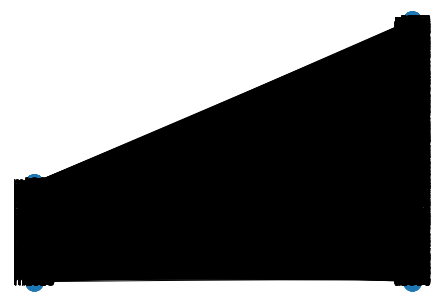

In [6]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [7]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))


number of movies  1292
number of actors  3411


In [8]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))


Number of random walks: 4703


In [9]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)
print(model.wv.vectors.shape)



(4703, 128)


In [10]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [11]:
print(node_ids[:15],end='')
print(node_targets[:15],end='')

['a973', 'a967', 'a964', 'a1731', 'a970', 'a969', 'a1057', 'a1028', 'a965', 'm1111', 'a1003', 'm1094', 'a959', 'm67', 'a966']['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'movie', 'actor', 'movie', 'actor']

In [12]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    aii=-1
    for i in node_ids:
        aii+=1
        if 'm' in i:
            movie_nodes.append(i)
            movie_embeddings.append(node_embeddings[aii])
        if 'a' in i:
            actor_nodes.append(i)
            actor_embeddings.append(node_embeddings[aii])
    
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

In [13]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)


<font color='cyan'>Graded function - 1</font>

In [14]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Graded function - 2</font>

In [15]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

In [19]:
def cost1(graph,number_of_cluster):
    '''In this function, we will calculate cost1'''
    connected_node_count = len(max(nx.connected_components(graph)))# this will give the total no of nodes present in the largest connected component
    total_nodes = len(graph.nodes())
    cost1 = connected_node_count/(total_nodes*number_of_cluster)
    return cost1

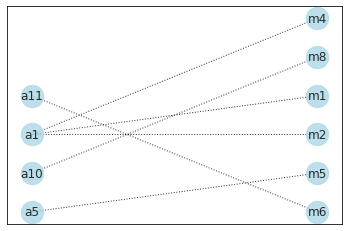

In [20]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Graded function - 3</font>

In [21]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

In [22]:
def cost2(graph,number_of_clusters,str='m'):
    '''In this function, we will calculate cost1'''
    mn=0
    for i in graph.nodes():
        if str in i:
                mn+=1
                
    cost2= (1/number_of_clusters)*(graph.number_of_edges()/mn)
    
    return cost2

<font color='cyan'>Graded function - 4</font>

In [23]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

## Task 1 : Apply clustering algorithm to group similar actors

In [25]:
#print(r)
mCost=[]
ActorArray=np.array(actor_embeddings)
for toclusters in [3, 5, 10, 30, 50, 100, 200, 500]:
    kmeans = KMeans(n_clusters=toclusters)
    kmeans.fit(actor_embeddings)

    cluLabel=kmeans.labels_
    Cost1=0
    Cost2=0
    for i in range(toclusters):
        U=nx.Graph()
        for j in range(len(cluLabel)):
            if cluLabel[j]==i:
                ego=actor_nodes[j]
                egonet=nx.ego_graph(A,ego)
                U=nx.compose(U,egonet)
        
        Cost1+=cost1(U,toclusters)
        Cost2+=cost2(U,toclusters,'m')
    metricCost=Cost1*Cost2
    #metricCost=FindCost_actorCluster(kmeans.labels_,toclusters)
    print('No of Cluster :', toclusters)
    print('metric Cost :', metricCost)
    mCost.append(metricCost)

print('Optimal Cost : ', np.max(mCost))

No of Cluster : 3
metric Cost : 3.7564125676958744
No of Cluster : 5
metric Cost : 2.5494455070109208
No of Cluster : 10
metric Cost : 2.117336680198817
No of Cluster : 30
metric Cost : 1.7208788949443787
No of Cluster : 50
metric Cost : 1.9239787623074314
No of Cluster : 100
metric Cost : 1.5773219717340397
No of Cluster : 200
metric Cost : 1.788507511032022
No of Cluster : 500
metric Cost : 1.8883257785556409
Optimal Cost :  3.7564125676958744


In [26]:
temp = 0
clusters=[3, 5, 10, 30, 50, 100, 200, 500]

for idx in range(0, len(mCost)): 
    if temp <= mCost[idx]: 
        temp=mCost[idx]
        oclus=clusters[idx]
        
print(oclus)

3


[1 1 1 ... 2 2 2]


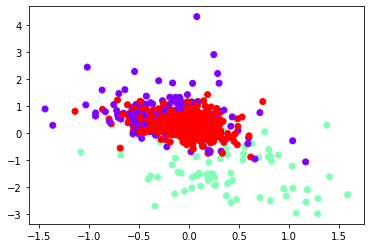

In [27]:
kmeans = KMeans(n_clusters=oclus)
kmeans.fit(actor_embeddings)
    
print(kmeans.labels_)
plt.scatter(ActorArray[:,0],ActorArray[:,1], c=kmeans.labels_, cmap='rainbow')
plt.show()


In [28]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]
print(node_ids[0:15])
print(node_targets[0:15])


['a973', 'a967', 'a964', 'a1731', 'a970', 'a969', 'a1057', 'a1028', 'a965', 'm1111', 'a1003', 'm1094', 'a959', 'm67', 'a966']
['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'movie', 'actor', 'movie', 'actor']


In [29]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)


(3411, 2)


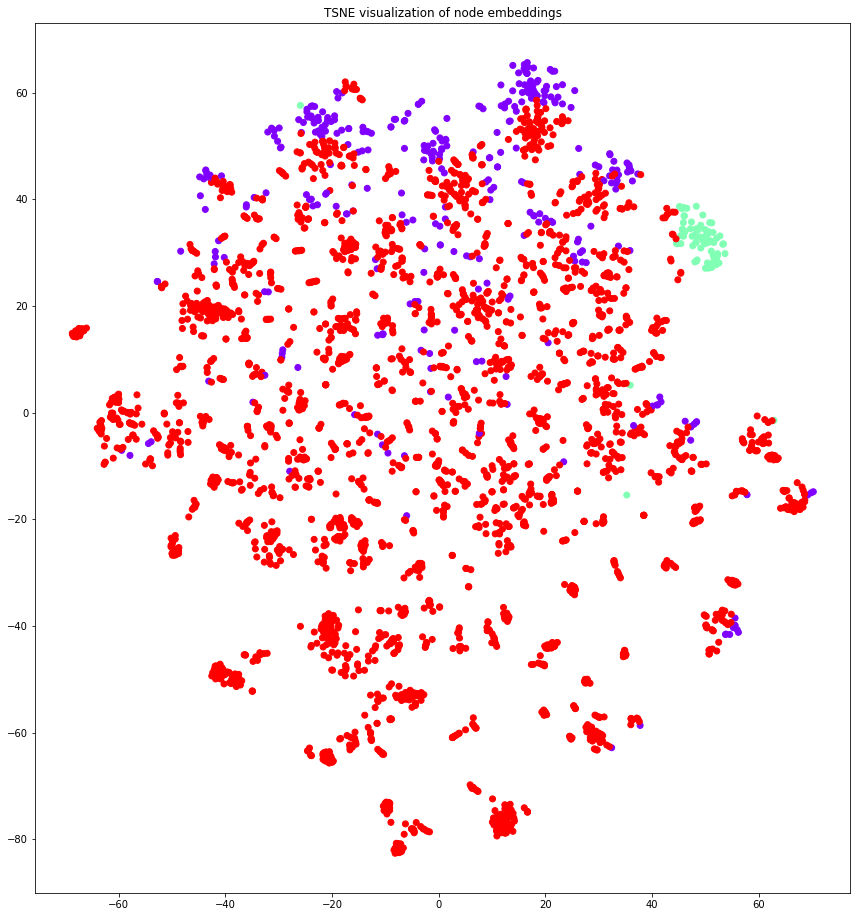

In [30]:
cluColor=kmeans.labels_
ActorNodeEmb=np.array(node_embeddings_2d)
#print(np.unique(node_targets))
#print(np.unique(cluColor))
print(node_embeddings_2d.shape)
label_map = { l: i for i, l in enumerate(np.unique(cluColor))}
node_colours = [ label_map[target] for target in cluColor]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(ActorNodeEmb[:,0], 
            ActorNodeEmb[:,1], 
            c=node_colours, cmap='rainbow')
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

## Task 2 : Apply clustering algorithm to group similar movies

In [31]:
MovieArray=np.array(movie_embeddings)
mCost=[]
for toclusters in [3, 5, 10, 30, 50, 100, 200, 500]:
    kmeans = KMeans(n_clusters=toclusters)
    kmeans.fit(movie_embeddings)
    Cost1=0
    Cost2=0
    cluLabel=kmeans.labels_
    for i in range(toclusters):
        U=nx.Graph()
        for j in range(len(cluLabel)):
            if cluLabel[j]==i:
                ego=movie_nodes[j]
                egonet=nx.ego_graph(A,ego)
                U=nx.compose(U,egonet)
        #print('Cluster no : ', i)
        Cost1+=cost1(U,toclusters)
        Cost2+=cost2(U,toclusters,'a')

    metricCost=(Cost1*Cost2)
    print('No of Cluster :', toclusters)
    print('metric Cost :', metricCost)
    mCost.append(metricCost)

print('Optimal Cost : ', np.max(mCost))

No of Cluster : 3
metric Cost : 2.842142034131471
No of Cluster : 5
metric Cost : 2.4746066474035593
No of Cluster : 10
metric Cost : 2.5281735229142908
No of Cluster : 30
metric Cost : 2.126295535013504
No of Cluster : 50
metric Cost : 1.8077298656365632
No of Cluster : 100
metric Cost : 1.6063320609535225
No of Cluster : 200
metric Cost : 1.3519537428882824
No of Cluster : 500
metric Cost : 1.1970145921873039
Optimal Cost :  2.842142034131471


In [32]:
temp = np.max(mCost) 
clusters=[3, 5, 10, 30, 50, 100, 200, 500]
res = [] 
for idx in range(0, len(mCost)): 
    if temp == mCost[idx]: 
        oclus=clusters[idx]
        
print(oclus)


3


[0 0 0 ... 2 2 2]


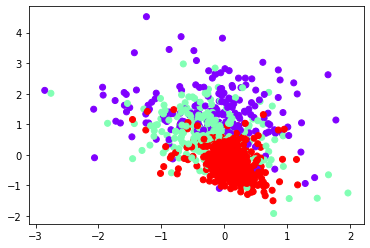

['a973', 'a967', 'a964', 'a1731', 'a970', 'a969', 'a1057', 'a1028', 'a965', 'm1111', 'a1003', 'm1094', 'a959', 'm67', 'a966']
['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'actor', 'movie', 'actor', 'movie', 'actor']


In [33]:

kmeans = KMeans(n_clusters=oclus)
kmeans.fit(movie_embeddings)
    
print(kmeans.labels_)
plt.scatter(MovieArray[:,0],MovieArray[:,1], c=kmeans.labels_, cmap='rainbow')
plt.show()

# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]
print(node_ids[0:15])
print(node_targets[0:15])


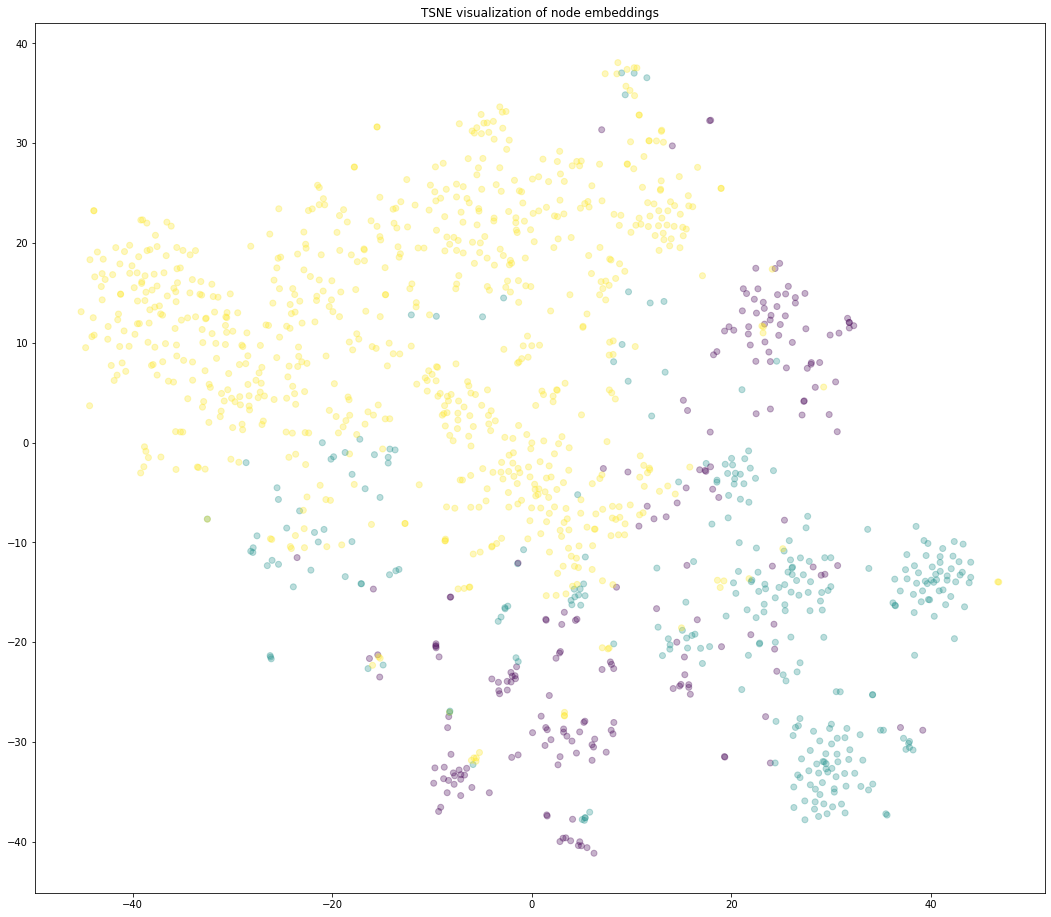

In [34]:

from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)

MovieNodeEmb=np.array(node_embeddings_2d)
# import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(kmeans.labels_))}
node_colours = [ label_map[target] for target in kmeans.labels_]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(MovieNodeEmb[:,0], 
            MovieNodeEmb[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

